In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = pd.read_csv('data_cleaned.csv')
print(data.shape)
data.head()

(337144, 9)


,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic,positive,clean_text
0,haha you guys are a bunch of losers.,0,1,0,0,0,1,0,haha guys bunch losers
1,ur a sh*tty comment.,0,0,1,0,0,1,0,tty comment
2,It's ridiculous that these guys are being call...,0,1,0,0,0,1,0,ridiculous guys called protesters armed threat...
3,Yet call out all Muslims for the acts of a few...,1,1,0,0,0,1,0,muslims acts pilloried okay smear entire relig...
4,This bitch is nuts. Who would read a book by a...,0,1,1,0,0,1,0,bitch nuts read book woman


In [3]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

(336740, 9)


In [4]:
labels= ['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
vectorizer = TfidfVectorizer(sublinear_tf=True)

vects = vectorizer.fit_transform(data['clean_text'])
target = data[labels].values

In [7]:
print('X shape', vects.shape)
print('Y shape', target.shape)

X shape (336740, 259211)
Y shape (336740, 6)


In [8]:
from utils.ml import train_model_one_vs_rest

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

Mean Score 0.8559 +- 0.0034
Mean Accuracy 0.751 +- 0.0024


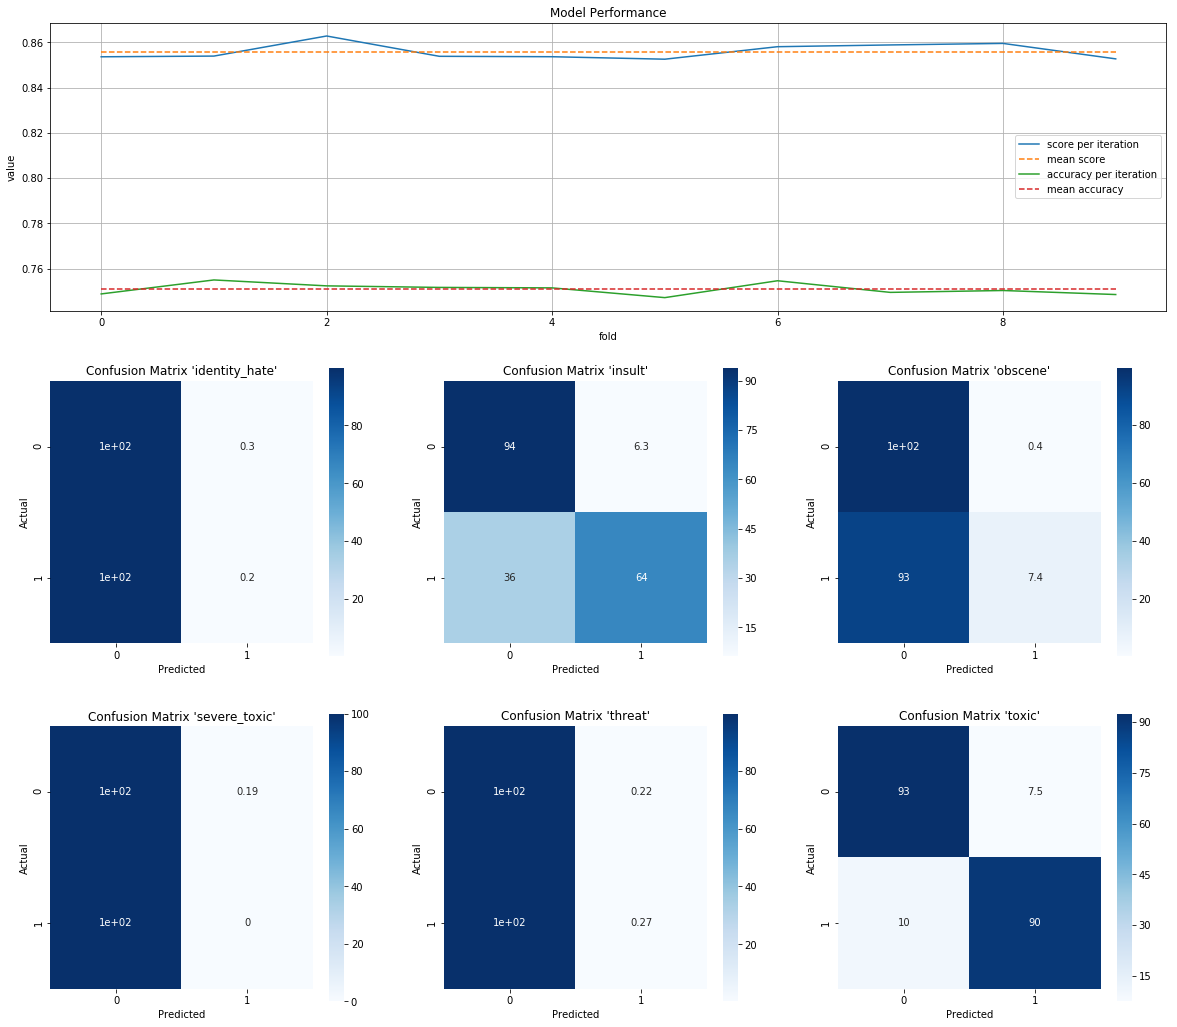

In [10]:
model = MultinomialNB()
mnb_performance, mnb_cm, mnb_model = train_model_one_vs_rest(model, vects, target, labels)
print('Mean Score', round(np.mean(mnb_performance['score']), 4), '+-', round(np.std(mnb_performance['score']), 4))
print('Mean Accuracy', round(np.mean(mnb_performance['accuracy']), 4), '+-', round(np.std(mnb_performance['accuracy']), 4))

Mean Score 0.973 +- 0.0006
Mean Accuracy 0.786 +- 0.0021


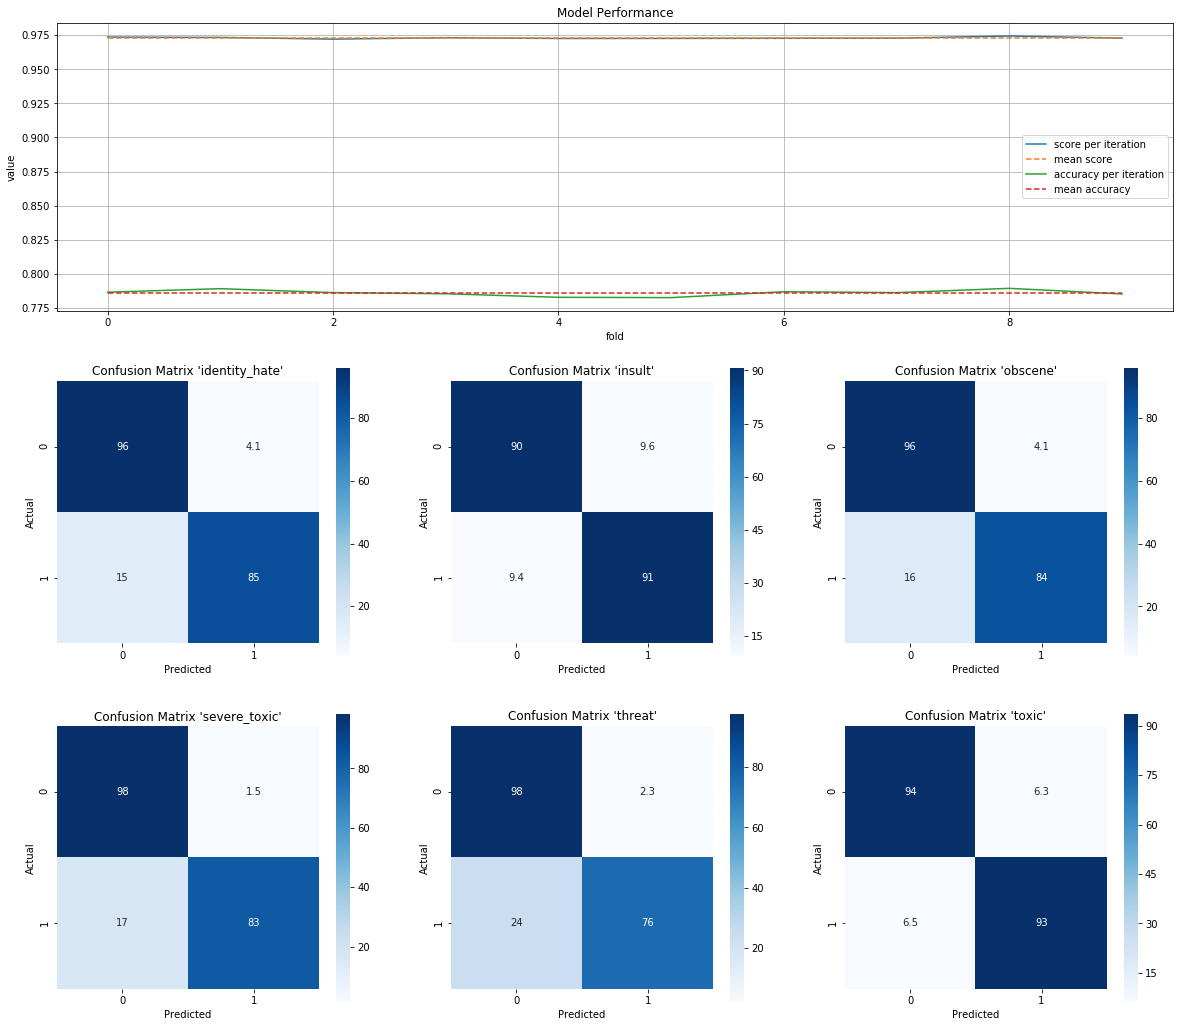

In [11]:
model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True)
lr_performance, lr_cm, lr_model = train_model_one_vs_rest(model, vects, target, labels)
print('Mean Score', round(np.mean(lr_performance['score']), 4), '+-', round(np.std(lr_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr_performance['accuracy']), 4), '+-', round(np.std(lr_performance['accuracy']), 4))

Mean Score 0.9713 +- 0.0005
Mean Accuracy 0.7638 +- 0.002


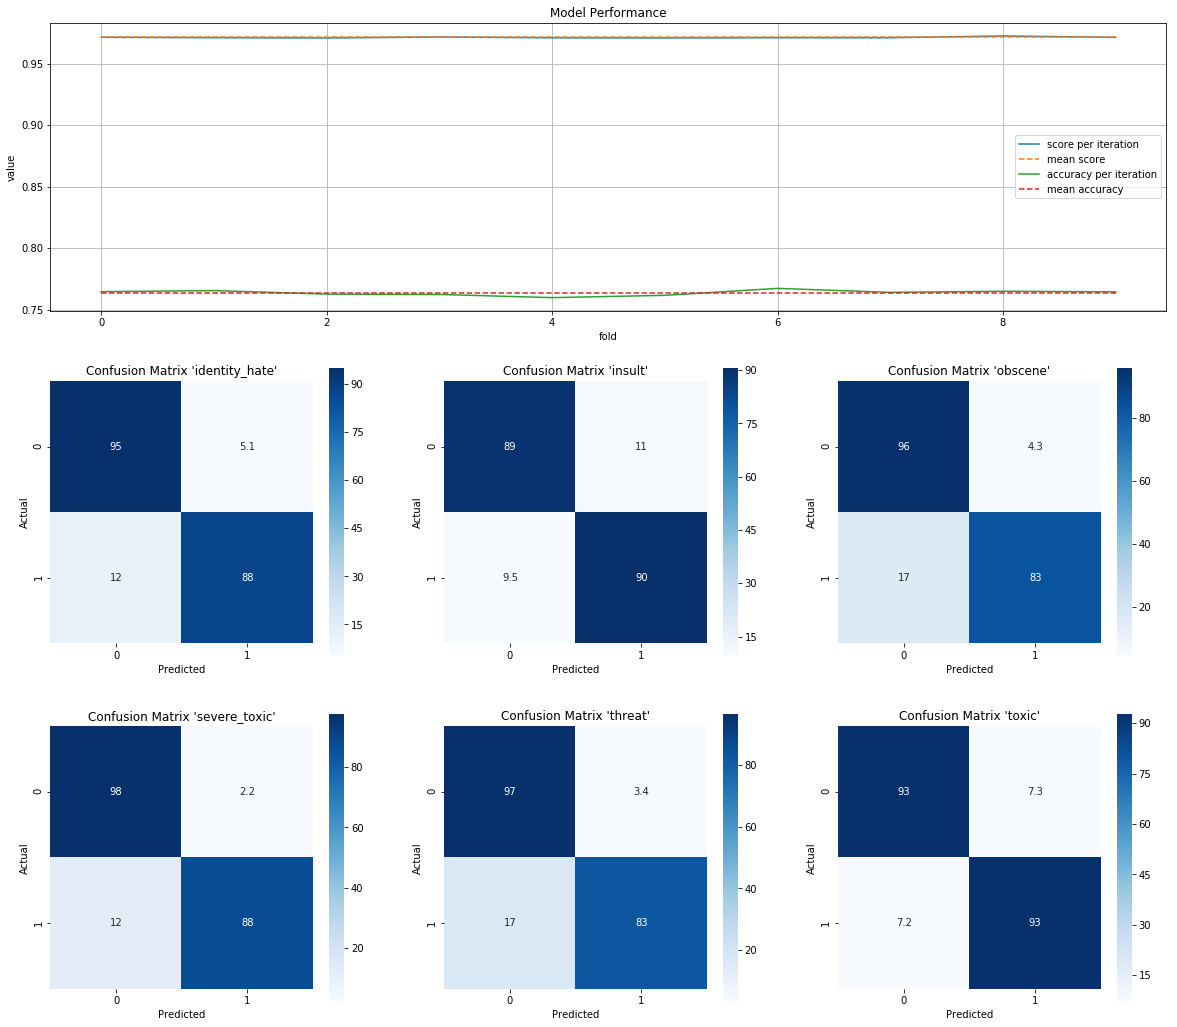

In [12]:
model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True,
                           C=0.1)
lr01_performance, lr01_cm, lr01_model = train_model_one_vs_rest(model, vects, target, labels)
print('Mean Score', round(np.mean(lr01_performance['score']), 4), '+-', round(np.std(lr01_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr01_performance['accuracy']), 4), '+-', round(np.std(lr01_performance['accuracy']), 4))

In [14]:
import pickle

In [15]:
pickle.dump(lr01_model, open('OneVsRest.pkl', 'wb'))